In [44]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from catboost import CatBoostRegressor, Pool
from math import erf, sqrt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNetCV
from scipy.stats import norm
from sklearn.ensemble import RandomForestRegressor
from tensorflow.keras import regularizers

#from random_forest import RandomForestRegressor

In [45]:
pd.set_option('display.max_columns', None)

In [46]:
#df= pd.read_stata("bl_el_clean.dta")
df_main_old = pd.read_stata("new_cleaned het data.dta")
df_main = pd.read_stata("cleaned het data 2.dta")

In [47]:
df_main.head(2)

,hhid,q_id,control,full,half,restricted,total_n,half_full,control_trt,two_project_fulla_1,ls_full,ls_rest,ls_half,ls_poultry_full,ls_poultry_rest,ls_poultry_half,male_designee_full,male_designee_half,treated_HHs,share_all,precovid,own_ls_e,small_ls_e,large_ls_e,medium_ls_e,own_ls,small_ls_bl,medium_ls_bl,large_ls_bl,w05_ls_value_e,w05_ls_value,fattening_ls_count,sold_ls,sold_ls_count,consumed_ls,consumed_ls_count,ls_stable,dwelling_type_bin_1,dwelling_type_bin_2,dwelling_type_bin_3,dwelling_type_bin_4,dwelling_type_bin_5,dwelling_type_bin_6,dwelling_ownership_b,dwelling_ownershi_2,dwelling_rent,tertile_dwellperpers,tertile_dwellperp_3,tertile_dwellperp_4,water_source_dist,hh_share_latrine,latrine,water_source_bin_2,water_source_bin_3,water_heating_source,water_heating_sou_5,water_heating_sou_6,water_heating_sou_7,water_heating_sou_8,water_heating_sou_9,sewage_e_bin_1,sewage_e_bin_2,sewage_e_bin_3,sewage_e_bin_4,sewage_e_bin_5,sewage_e_bin_6,ceiling_e_bin_1,ceiling_e_bin_2,ceiling_e_bin_3,ceiling_e_bin_4,ceiling_e_bin_5,ceiling_e_bin_6,ceiling_e_bin_7,ceiling_e_bin_9,flooring_e_bin_1,flooring_e_bin_2,flooring_e_bin_3,flooring_e_bin_4,flooring_e_bin_5,lighting_e_bin_1,lighting_e_bin_2,lighting_e_bin_4,home_improve_src__10,home_improve_src__11,home_improve_src__12,home_improve_src__13,home_improve_src__14,home_improve_src__15,home_improve_amount,ratio_smart_mobil_16,cart_e,bicycle_e,vehicle_toktok_e,vehicle_tricycle_e,vehicle_motorcycle_e,has_fridge_e,has_tv_lcd_e,has_wash_fullyauto_e,has_heater_e,skip_meal_e,ratio_skiptimes_p_17,worry_about_food,got_medical_assist,medical_assist_place,medical_assist_pl_18,medical_assist_pl_19,medical_assist_pl_20,medical_assist_money,medical_assist_mo_21,medical_assist_mo_22,medical_assist_mo_23,ladder,ratio_eatoutside__24,non_food_imputed__25,nonfood_exp_mon_bl,food_exp_bl,nonagri_grp_proce_26,nonagri_grp_buy_sell,nonagri_grp_services,nonagri_atleast1_loc,nonagri_atleast1__27,nonagri_sumcapital,agri_own_yesno,agri_own_size_quir,agri_rent_yesno,agri_rent_size_quir,agri_rent_type_bin_2,agri_rent_type_bin_3,agri_rent_amount_bl,agri_rent_out_yesno,agri_rent_out_siz_28,agri_rent_out_type_b,agri_rent_out_typ_29,agri_rent_out_amount,agri_l_assets_cart,agri_l_assets_shovel,agri_l_assets_plow,agri_l_assets_sickle,agri_l_assets_other,agri_l_assets_non,hhmembers_agri_work,bl_fruit_trees_count,totalincome_witho_32,totalincome_1mo,femhd,oldhd,younghd,singhd,illithd,haschld,propdisabled_ill,hhdisabl_chld,hhdisabl_adult,can_start_busines_33,worked_with_busin_34,use_time_forrev_atl,use_time_rev_30da_35,use_time_foredu_atl,use_time_edu_30da_36,nobank_r_too_far_atl,nobank_r_too_expe_37,nobank_r_lack_of__38,nobank_r_no_trust_39,nobank_r_religiou_40,nobank_r_not_enou_41,nobank_r_some1_el_42,nobank_r_no_need_atl,rosca_r_nonfarm_e_43,rosca_r_for_marri_44,rosca_r_for_educa_45,rosca_r_buy_a_hou_46,rosca_r_medical_e_47,rosca_r_loss_of_a_48,rosca_r_other_atl,help_mother_bin_2_49,help_mother_bin_3_50,help_father_bin_2_51,help_father_bin_3_52,help_siblings_bin_53,help_siblings_bin_54,help_hhmembers_outsi,help_hhmembers_ou_55,help_friends_bin__56,help_friends_bin__57,help_others_bin_2_58,help_others_bin_3_59,health_cant_work__60,health_cant_work__61,dm_food_atleast,dm_cloth_atleast,dm_educ_atleast,dm_health_atleast,dm_home_atleast,dm_food_influence_bi,dm_food_influence_62,dm_food_influence_63,dm_cloth_influence_b,dm_cloth_influenc_64,dm_cloth_influenc_65,dm_educ_influence_bi,dm_educ_influence_66,dm_educ_influence_67,dm_health_influence_,dm_health_influen_68,dm_health_influen_69,dm_home_influence_bi,dm_home_influence_70,dm_home_influence_71,dm_money_earn_bin_72,dm_money_earn_bin_73,dm_money_earn_bin_74,dm_money_earn_bin_75,dm_spouse_earn_bi_76,dm_spouse_earn_bi_77,dm_spouse_earn_bi_78,dm_spouse_earn_bi_79,dm_daily_spend_bi_80,dm_daily_spend_bi_81,dm_daily_spend_bi_82,dm_daily_spend_bi_83,dm_major_spend_bi_84,dm_major_spend_bi_85,dm_major_spend_bi_86,dm_major_spend_bi_87,dm_fplan_child_bi_88,dm_fplan_child_bi_89,dm_fplan_chi

In [48]:
df_main['_merge'].value_counts()

_merge
Matched (3)    3206
Name: count, dtype: int64

In [49]:
df_main.shape

(3206, 281)

---

# Calculating p(Z) for each household/row

#### First identifying the columns that we will use (columns in the new DF but not in the old one)

In [50]:
df_main_old_col_names = set(df_main_old.columns)

df_main_col_names = set(df_main.columns)


exlusive_col_names = df_main_col_names- df_main_old_col_names


df_main_exclusive = df_main.loc[:,list(exlusive_col_names)]
df_main_exclusive.head()

,control_trt,_merge,restricted,control,total_n,full,half_full,half
0,1.466667,Matched (3),3.0,22.0,37.0,8.0,0.363636,4.0
1,0.617647,Matched (3),5.0,21.0,55.0,11.0,1.125000,18.0
2,0.640000,Matched (3),12.0,16.0,41.0,5.0,0.470588,8.0
3,1.466667,Matched (3),3.0,22.0,37.0,8.0,0.363636,4.0
4,1.000000,Matched (3),3.0,20.0,40.0,12.0,0.333333,5.0


##### Combining resticted and full

In [51]:
df_main['full'] = df_main['full'] + df_main['restricted']
df_main.drop(columns=['restricted'], inplace=True)

In [52]:
df_main_old_col_names = set(df_main_old.columns)

df_main_col_names = set(df_main.columns)


exlusive_col_names = df_main_col_names- df_main_old_col_names


df_main_exclusive = df_main.loc[:,list(exlusive_col_names)]
df_main_exclusive.head()

,control_trt,_merge,control,total_n,full,half_full,half
0,1.466667,Matched (3),22.0,37.0,11.0,0.363636,4.0
1,0.617647,Matched (3),21.0,55.0,16.0,1.125000,18.0
2,0.640000,Matched (3),16.0,41.0,17.0,0.470588,8.0
3,1.466667,Matched (3),22.0,37.0,11.0,0.363636,4.0
4,1.000000,Matched (3),20.0,40.0,15.0,0.333333,5.0


In [53]:
print(df_main[df_main['full'] ==0].shape[0])
print(df_main[df_main['half'] ==1].shape[0])
print(df_main[df_main['control'] ==0].shape[0])

0
0
0


### Combining the full cost and full cost restricted into one full cost variable

In [54]:
df_main['treatment'].value_counts()

treatment
Control                  935
Full cost                793
Full cost, restricted    771
Half cost                707
Name: count, dtype: int64

In [55]:
df_main['treatment'] = np.where(df_main['treatment'].isin(['Full cost','Full cost, restricted']), 'Full cost',df_main['treatment'] )

In [56]:
df_main['treatment'].value_counts()

treatment
Full cost    1564
Control       935
Half cost     707
Name: count, dtype: int64

### Calculating p(Z) based on whether the value is in the Full cost, Half cost, or Control group.

In [58]:
# calculate p(Z) for full vs control
F = df_main['full'].astype(float)     
C = df_main['control'].astype(float)
mask_F_vs_C = df_main['treatment'].isin(['Full cost','Control'])

df_main['p(Z)_full_vs_control'] = np.nan
df_main.loc[(mask_F_vs_C) & (df_main['treatment'].eq('Full cost')), 'p(Z)_full_vs_control'] = (F/(F+C)) # This says for rows in the mask (Full cost, Control), for rows where treatment equals Full cost, set the value of p(Z)_full_vs_control to (F/(F+C))
df_main.loc[(mask_F_vs_C) & (df_main['treatment'].eq('Control')),   'p(Z)_full_vs_control'] = (C/(F+C))

# calculate p(Z) for Hald vs Control
H = df_main['half'].astype(float)     
mask_H_vs_C = df_main['treatment'].isin(['Half cost','Control'])

df_main['p(Z)_half_vs_control'] = np.nan
df_main.loc[(mask_H_vs_C) & (df_main['treatment'].eq('Half cost')), 'p(Z)_half_vs_control'] = (H/(H+C))
df_main.loc[(mask_H_vs_C) & (df_main['treatment'].eq('Control')),   'p(Z)_half_vs_control'] = (C/(H+C))

# calculate p(Z) for Full vs Half
mask_F_vs_H = df_main['treatment'].isin(['Full cost','Half cost'])

df_main['p(Z)_full_vs_half'] = np.nan
df_main.loc[(mask_F_vs_H) & (df_main['treatment'].eq('Full cost')), 'p(Z)_full_vs_half'] = (F/(F+H))
df_main.loc[(mask_F_vs_H) & (df_main['treatment'].eq('Half cost')),   'p(Z)_full_vs_half'] = (H/(F+H))


C:\Users\ahmed\AppData\Local\Temp\ipykernel_43764\3080349285.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main['p(Z)_full_vs_control'] = np.nan
C:\Users\ahmed\AppData\Local\Temp\ipykernel_43764\3080349285.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main['p(Z)_half_vs_control'] = np.nan
C:\Users\ahmed\AppData\Local\Temp\ipykernel_43764\3080349285.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider j

In [59]:
print(df_main[df_main['treatment'].isin(['Full cost','Control'])].shape[0])
print(df_main['p(Z)_full_vs_control'].notna().sum())

2499
2499


- Now when we filter by the population inside the function, we will get a p(Z) column for that population. 
- Note that although the p(Z) columns have missing, but after we filter by the population, we will get a p(Z) fir that population with no missing values.

#### Dropping the new not unneeded columns:

In [60]:
df_main.drop(columns=['half_full','control_trt','full','half','total_n','_merge','control'], inplace=True)

In [61]:
# List of all p(Z) variables
p_z_list = ['p(Z)_full_vs_control','p(Z)_half_vs_control','p(Z)_full_vs_half']

---

## Y values

In [62]:
#Removing the amout that we given to the treatment group from their reported values
df_main['own_value_ls'] = np.where(df_main['treatment'] == 1,df_main['own_value_ls'] - 11379.31, df_main['own_value_ls'] )

###### Note: **inflated_ls_hh is a Y variable and only has 3 unique float values**

In [ ]:
#df_main['log_ elset_sh_eq'] = np.log1p(df_main['elset_sh_eq'])
#df_main['log_ totalincome_1mo'] = np.log1p(df_main['totalincome_1mo'])

In [74]:
#df_main['own_value_ls'] = np.log1p(df_main['own_value_ls'])

In [75]:
df_main['own_value_ls'].describe()

count      3206.000000
mean      10031.263672
std       21096.554688
min           0.000000
25%           0.000000
50%        1071.666626
75%        7000.000000
max      262300.000000
Name: own_value_ls, dtype: float64

In [76]:
df_main['totalincome_1mo'].describe()

count     3206.000000
mean      1089.408936
std       1507.125122
min          0.000000
25%        311.250008
50%        500.000000
75%       1400.000000
max      10040.000000
Name: totalincome_1mo, dtype: float64

In [77]:
df_main['own_value_ls'].describe()

count      3206.000000
mean      10031.263672
std       21096.554688
min           0.000000
25%           0.000000
50%        1071.666626
75%        7000.000000
max      262300.000000
Name: own_value_ls, dtype: float64

In [78]:
df_main[df_main['elset_sh_eq'] > 30].describe()

,two_project_fulla_1,ls_full,ls_rest,ls_half,ls_poultry_full,ls_poultry_rest,ls_poultry_half,male_designee_full,male_designee_half,treated_HHs,share_all,precovid,own_ls_e,small_ls_e,large_ls_e,medium_ls_e,small_ls_bl,medium_ls_bl,large_ls_bl,w05_ls_value_e,w05_ls_value,fattening_ls_count,sold_ls,sold_ls_count,consumed_ls,consumed_ls_count,dwelling_type_bin_1,dwelling_type_bin_2,dwelling_type_bin_3,dwelling_type_bin_4,dwelling_type_bin_5,dwelling_type_bin_6,dwelling_ownership_b,dwelling_ownershi_2,dwelling_rent,tertile_dwellperpers,tertile_dwellperp_3,tertile_dwellperp_4,water_source_dist,hh_share_latrine,water_source_bin_2,water_source_bin_3,water_heating_source,water_heating_sou_5,water_heating_sou_6,water_heating_sou_7,water_heating_sou_8,water_heating_sou_9,sewage_e_bin_1,sewage_e_bin_2,sewage_e_bin_3,sewage_e_bin_4,sewage_e_bin_5,sewage_e_bin_6,ceiling_e_bin_1,ceiling_e_bin_2,ceiling_e_bin_3,ceiling_e_bin_4,ceiling_e_bin_5,ceiling_e_bin_6,ceiling_e_bin_7,ceiling_e_bin_9,flooring_e_bin_1,flooring_e_bin_2,flooring_e_bin_3,flooring_e_bin_4,flooring_e_bin_5,lighting_e_bin_1,lighting_e_bin_2,lighting_e_bin_4,home_improve_src__10,home_improve_src__11,home_improve_src__12,home_improve_src__13,home_improve_src__14,home_improve_src__15,home_improve_amount,ratio_smart_mobil_16,has_tv_lcd_e,has_wash_fullyauto_e,ratio_skiptimes_p_17,medical_assist_place,medical_assist_pl_18,medical_assist_pl_19,medical_assist_pl_20,medical_assist_money,medical_assist_mo_21,medical_assist_mo_22,medical_assist_mo_23,ratio_eatoutside__24,non_food_imputed__25,nonfood_exp_mon_bl,food_exp_bl,nonagri_grp_proce_26,nonagri_grp_buy_sell,nonagri_grp_services,nonagri_atleast1_loc,nonagri_atleast1__27,nonagri_sumcapital,agri_own_size_quir,agri_rent_size_quir,agri_rent_type_bin_2,agri_rent_type_bin_3,agri_rent_amount_bl,agri_rent_out_siz_28,agri_rent_out_type_b,agri_rent_out_typ_29,agri_rent_out_amount,agri_l_assets_cart,agri_l_assets_shovel,agri_l_assets_plow,agri_l_assets_sickle,agri_l_assets_other,agri_l_assets_non,bl_fruit_trees_count,totalincome_witho_32,totalincome_1mo,propdisabled_ill,can_start_busines_33,worked_with_busin_34,use_time_forrev_atl,use_time_rev_30da_35,use_time_foredu_atl,use_time_edu_30da_36,nobank_r_too_far_atl,nobank_r_too_expe_37,nobank_r_lack_of__38,nobank_r_no_trust_39,nobank_r_religiou_40,nobank_r_not_enou_41,nobank_r_some1_el_42,nobank_r_no_need_atl,rosca_r_nonfarm_e_43,rosca_r_for_marri_44,rosca_r_for_educa_45,rosca_r_buy_a_hou_46,rosca_r_medical_e_47,rosca_r_loss_of_a_48,rosca_r_other_atl,help_mother_bin_2_49,help_mother_bin_3_50,help_father_bin_2_51,help_father_bin_3_52,help_siblings_bin_53,help_siblings_bin_54,help_hhmembers_outsi,help_hhmembers_ou_55,help_friends_bin__56,help_friends_bin__57,help_others_bin_2_58,help_others_bin_3_59,health_cant_work__60,health_cant_work__61,dm_food_atleast,dm_cloth_atleast,dm_educ_atleast,dm_health_atleast,dm_home_atleast,dm_food_influence_bi,dm_food_influence_62,dm_food_influence_63,dm_cloth_influence_b,dm_cloth_influenc_64,dm_cloth_influenc_65,dm_educ_influence_bi,dm_educ_influence_66,dm_educ_influence_67,dm_health_influence_,dm_health_influen_68,dm_health_influen_69,dm_home_influence_bi,dm_home_influence_70,dm_home_influence_71,dm_money_earn_bin_72,dm_money_earn_bin_73,dm_money_earn_bin_74,dm_money_earn_bin_75,dm_spouse_earn_bi_76,dm_spouse_earn_bi_77,dm_spouse_earn_bi_78,dm_spouse_earn_bi_79,dm_daily_spend_bi_80,dm_daily_spend_bi_81,dm_daily_spend_bi_82,dm_daily_spend_bi_83,dm_major_spend_bi_84,dm_major_spend_bi_85,dm_major_spend_bi_86,dm_major_spend_bi_87,dm_fplan_child_bi_88,dm_fplan_child_bi_89,dm_fplan_child_bi_90,dm_fplan_child_bi_91,dm_child_educ_bin_92,dm_child_educ_bin_93,dm_child_educ_bin_94,dm_child_educ_bin_95,dm_business_bin_1_96,dm_business_bin_2_97,dm_business_bin_3_98,dm_business_bin_4_99,health_rank_bin_1_100,health_rank_bin_2_101,health_rank_bin_3_102,health_rank_bin_4_103,health_doctor_vis_104,life_satisf_bin_1_105,life_satisf_bin_2_106,life_satisf_bin_4_107,life_satisf_bin_5_

In [79]:
df_main['elset_sh_eq'].describe()

count    3206.000000
mean        3.186223
std         5.912060
min         0.000000
25%         0.000000
50%         0.388333
75%         2.308333
max        50.320000
Name: elset_sh_eq, dtype: float64

In [80]:
df_main[df_main['elset_sh_eq'] > 30].shape[0]

15

In [81]:
df_main[(df_main['elset_sh_eq'].rank(pct=True) >= 0.90) & (df_main['elset_sh_eq']>=100)].shape[0]


0

In [82]:
print(f"{df_main[df_main['elset_sh_eq'].rank(pct=True).between(0.95, 1)]['own_value_ls'].mean()}")
print(f"{df_main[df_main['elset_sh_eq'].rank(pct=True).between(0.95, 1)]['own_value_ls'].median()}")

66843.7109375
60170.0


In [83]:
df_main['elset_sh_eq'].quantile(0.95) #filter by 95th percentile only for this variable run

np.float64(18.00250005722046)

In [84]:
df_main['elset_sh_eq'].quantile(0.95) / df_main['elset_sh_eq'].shape[0]

np.float64(0.00561525266912678)

(array([1.787e+03, 3.780e+02, 1.330e+02, 7.000e+01, 5.300e+01, 3.700e+01,
        3.600e+01, 2.100e+01, 1.100e+01, 1.100e+01, 4.000e+00, 1.100e+01,
        7.000e+00, 3.000e+00, 3.000e+00, 1.000e+00, 3.200e+01, 5.800e+01,
        2.500e+01, 3.600e+01, 1.400e+02, 6.800e+01, 4.200e+01, 2.300e+01,
        1.300e+01, 8.000e+00, 8.000e+00, 6.000e+00, 2.000e+00, 2.000e+00,
        2.000e+00, 2.000e+00, 1.000e+00, 6.000e+00, 5.000e+00, 0.000e+00,
        6.000e+00, 7.000e+00, 3.000e+00, 7.000e+00, 4.300e+01, 3.100e+01,
        1.000e+01, 8.000e+00, 6.000e+00, 5.000e+00, 3.000e+00, 7.000e+00,
        1.000e+00, 2.000e+00, 1.000e+00, 2.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 1.000e+00, 1.000e+00,
        2.000e+00, 1.000e+00, 1.000e+00, 2.000e+00, 0.000e+00, 2.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        2.000e+00, 0.000e+00, 0.000e+0

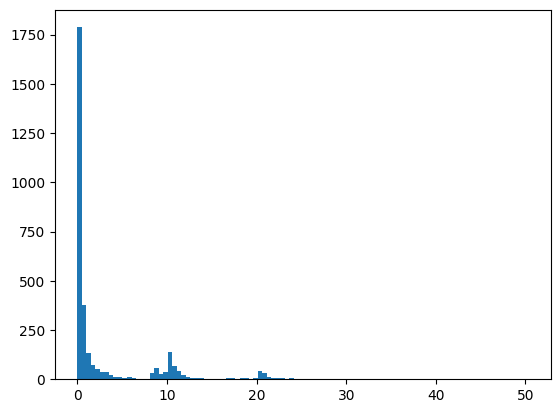

In [85]:
plt.hist(df_main['elset_sh_eq'],bins=100)

In [86]:
all_y_list = ["own_value_ls","totalincome_1mo","elset_sh_eq","tot_exp_2"]

In [87]:
# Log of the y, Experimental:
#all_y_list = ["own_value_ls","totalincome_1mo","elset_sh_eq","tot_exp_2","inflated_ls_hh"]

#df_main['totalincome_1mo'] = np.log1p(df_main['totalincome_1mo'])

---

### Cleaning ID and other irrelevant columns

In [88]:
# Chcecking all cols types
unique_dtypes = df_main.dtypes.map(lambda dt: dt.name).unique()
print(unique_dtypes)

['object' 'float32' 'category' 'int8' 'int16' 'int32' 'float64']


In [89]:
object_columns = df_main.select_dtypes(include=['object']).columns
object_columns 

Index(['hhid', 'q_id', 'hhid_id', 'agg_id', 'treatment'], dtype='object')

In [90]:
df_main.drop(columns=['hhid', 'hhid_id', 'agg_id', 'q_id','nn','inflated_ls_hh'], inplace=True)
object_columns = df_main.select_dtypes(include=['object']).columns
object_columns 

Index(['treatment'], dtype='object')

## Categorical Variables Cleaning

In [91]:
df_main['ladder'].value_counts()

ladder
1 - extremly poor living        1803
2                                420
5                                379
3                                376
4                                196
6                                 24
10 - very comfortable living       4
8                                  2
2.077067                           1
7                                  1
Name: count, dtype: int64

In [92]:
# 1) Drop the row(s) with ladder == 2.077067 
df_main = df_main[~df_main["ladder"].astype(str).str.strip().eq("2.077067")].copy()

# 2) Convert labels like "1 - extremly poor living" and "10 - very comfortable living" to integers
df_main["ladder"] = df_main["ladder"].astype(str).str.extract(r"^\s*(\d+)")[0].astype(int)

#### Converting the binary columns from string to int

In [93]:
df_main.head(3)

,two_project_fulla_1,ls_full,ls_rest,ls_half,ls_poultry_full,ls_poultry_rest,ls_poultry_half,male_designee_full,male_designee_half,treated_HHs,share_all,precovid,own_ls_e,small_ls_e,large_ls_e,medium_ls_e,own_ls,small_ls_bl,medium_ls_bl,large_ls_bl,w05_ls_value_e,w05_ls_value,fattening_ls_count,sold_ls,sold_ls_count,consumed_ls,consumed_ls_count,ls_stable,dwelling_type_bin_1,dwelling_type_bin_2,dwelling_type_bin_3,dwelling_type_bin_4,dwelling_type_bin_5,dwelling_type_bin_6,dwelling_ownership_b,dwelling_ownershi_2,dwelling_rent,tertile_dwellperpers,tertile_dwellperp_3,tertile_dwellperp_4,water_source_dist,hh_share_latrine,latrine,water_source_bin_2,water_source_bin_3,water_heating_source,water_heating_sou_5,water_heating_sou_6,water_heating_sou_7,water_heating_sou_8,water_heating_sou_9,sewage_e_bin_1,sewage_e_bin_2,sewage_e_bin_3,sewage_e_bin_4,sewage_e_bin_5,sewage_e_bin_6,ceiling_e_bin_1,ceiling_e_bin_2,ceiling_e_bin_3,ceiling_e_bin_4,ceiling_e_bin_5,ceiling_e_bin_6,ceiling_e_bin_7,ceiling_e_bin_9,flooring_e_bin_1,flooring_e_bin_2,flooring_e_bin_3,flooring_e_bin_4,flooring_e_bin_5,lighting_e_bin_1,lighting_e_bin_2,lighting_e_bin_4,home_improve_src__10,home_improve_src__11,home_improve_src__12,home_improve_src__13,home_improve_src__14,home_improve_src__15,home_improve_amount,ratio_smart_mobil_16,cart_e,bicycle_e,vehicle_toktok_e,vehicle_tricycle_e,vehicle_motorcycle_e,has_fridge_e,has_tv_lcd_e,has_wash_fullyauto_e,has_heater_e,skip_meal_e,ratio_skiptimes_p_17,worry_about_food,got_medical_assist,medical_assist_place,medical_assist_pl_18,medical_assist_pl_19,medical_assist_pl_20,medical_assist_money,medical_assist_mo_21,medical_assist_mo_22,medical_assist_mo_23,ladder,ratio_eatoutside__24,non_food_imputed__25,nonfood_exp_mon_bl,food_exp_bl,nonagri_grp_proce_26,nonagri_grp_buy_sell,nonagri_grp_services,nonagri_atleast1_loc,nonagri_atleast1__27,nonagri_sumcapital,agri_own_yesno,agri_own_size_quir,agri_rent_yesno,agri_rent_size_quir,agri_rent_type_bin_2,agri_rent_type_bin_3,agri_rent_amount_bl,agri_rent_out_yesno,agri_rent_out_siz_28,agri_rent_out_type_b,agri_rent_out_typ_29,agri_rent_out_amount,agri_l_assets_cart,agri_l_assets_shovel,agri_l_assets_plow,agri_l_assets_sickle,agri_l_assets_other,agri_l_assets_non,hhmembers_agri_work,bl_fruit_trees_count,totalincome_witho_32,totalincome_1mo,femhd,oldhd,younghd,singhd,illithd,haschld,propdisabled_ill,hhdisabl_chld,hhdisabl_adult,can_start_busines_33,worked_with_busin_34,use_time_forrev_atl,use_time_rev_30da_35,use_time_foredu_atl,use_time_edu_30da_36,nobank_r_too_far_atl,nobank_r_too_expe_37,nobank_r_lack_of__38,nobank_r_no_trust_39,nobank_r_religiou_40,nobank_r_not_enou_41,nobank_r_some1_el_42,nobank_r_no_need_atl,rosca_r_nonfarm_e_43,rosca_r_for_marri_44,rosca_r_for_educa_45,rosca_r_buy_a_hou_46,rosca_r_medical_e_47,rosca_r_loss_of_a_48,rosca_r_other_atl,help_mother_bin_2_49,help_mother_bin_3_50,help_father_bin_2_51,help_father_bin_3_52,help_siblings_bin_53,help_siblings_bin_54,help_hhmembers_outsi,help_hhmembers_ou_55,help_friends_bin__56,help_friends_bin__57,help_others_bin_2_58,help_others_bin_3_59,health_cant_work__60,health_cant_work__61,dm_food_atleast,dm_cloth_atleast,dm_educ_atleast,dm_health_atleast,dm_home_atleast,dm_food_influence_bi,dm_food_influence_62,dm_food_influence_63,dm_cloth_influence_b,dm_cloth_influenc_64,dm_cloth_influenc_65,dm_educ_influence_bi,dm_educ_influence_66,dm_educ_influence_67,dm_health_influence_,dm_health_influen_68,dm_health_influen_69,dm_home_influence_bi,dm_home_influence_70,dm_home_influence_71,dm_money_earn_bin_72,dm_money_earn_bin_73,dm_money_earn_bin_74,dm_money_earn_bin_75,dm_spouse_earn_bi_76,dm_spouse_earn_bi_77,dm_spouse_earn_bi_78,dm_spouse_earn_bi_79,dm_daily_spend_bi_80,dm_daily_spend_bi_81,dm_daily_spend_bi_82,dm_daily_spend_bi_83,dm_major_spend_bi_84,dm_major_spend_bi_85,dm_major_spend_bi_86,dm_major_spend_bi_87,dm_fplan_child_bi_88,dm_fplan_child_bi_89,dm_fplan_child_bi_90,dm_fplan_child_bi_91,dm_child_educ_bin_92,dm_child_educ_bin_

In [94]:
yes_no_cols = ['own_ls','ls_stable','latrine','worry_about_food','got_medical_assist',
               'agri_own_yesno', 'agri_rent_yesno', 'agri_rent_out_yesno', 'hhmembers_agri_work', 
               'cart_e', 'bicycle_e', 'vehicle_toktok_e', 'vehicle_tricycle_e', 'vehicle_motorcycle_e', 
               'has_fridge_e','skip_meal_e','has_heater_e']

for col in yes_no_cols:
    df_main[col] = np.where(df_main[col] == 'Yes', 1, 0)

In [95]:
df_main.head(3)

,two_project_fulla_1,ls_full,ls_rest,ls_half,ls_poultry_full,ls_poultry_rest,ls_poultry_half,male_designee_full,male_designee_half,treated_HHs,share_all,precovid,own_ls_e,small_ls_e,large_ls_e,medium_ls_e,own_ls,small_ls_bl,medium_ls_bl,large_ls_bl,w05_ls_value_e,w05_ls_value,fattening_ls_count,sold_ls,sold_ls_count,consumed_ls,consumed_ls_count,ls_stable,dwelling_type_bin_1,dwelling_type_bin_2,dwelling_type_bin_3,dwelling_type_bin_4,dwelling_type_bin_5,dwelling_type_bin_6,dwelling_ownership_b,dwelling_ownershi_2,dwelling_rent,tertile_dwellperpers,tertile_dwellperp_3,tertile_dwellperp_4,water_source_dist,hh_share_latrine,latrine,water_source_bin_2,water_source_bin_3,water_heating_source,water_heating_sou_5,water_heating_sou_6,water_heating_sou_7,water_heating_sou_8,water_heating_sou_9,sewage_e_bin_1,sewage_e_bin_2,sewage_e_bin_3,sewage_e_bin_4,sewage_e_bin_5,sewage_e_bin_6,ceiling_e_bin_1,ceiling_e_bin_2,ceiling_e_bin_3,ceiling_e_bin_4,ceiling_e_bin_5,ceiling_e_bin_6,ceiling_e_bin_7,ceiling_e_bin_9,flooring_e_bin_1,flooring_e_bin_2,flooring_e_bin_3,flooring_e_bin_4,flooring_e_bin_5,lighting_e_bin_1,lighting_e_bin_2,lighting_e_bin_4,home_improve_src__10,home_improve_src__11,home_improve_src__12,home_improve_src__13,home_improve_src__14,home_improve_src__15,home_improve_amount,ratio_smart_mobil_16,cart_e,bicycle_e,vehicle_toktok_e,vehicle_tricycle_e,vehicle_motorcycle_e,has_fridge_e,has_tv_lcd_e,has_wash_fullyauto_e,has_heater_e,skip_meal_e,ratio_skiptimes_p_17,worry_about_food,got_medical_assist,medical_assist_place,medical_assist_pl_18,medical_assist_pl_19,medical_assist_pl_20,medical_assist_money,medical_assist_mo_21,medical_assist_mo_22,medical_assist_mo_23,ladder,ratio_eatoutside__24,non_food_imputed__25,nonfood_exp_mon_bl,food_exp_bl,nonagri_grp_proce_26,nonagri_grp_buy_sell,nonagri_grp_services,nonagri_atleast1_loc,nonagri_atleast1__27,nonagri_sumcapital,agri_own_yesno,agri_own_size_quir,agri_rent_yesno,agri_rent_size_quir,agri_rent_type_bin_2,agri_rent_type_bin_3,agri_rent_amount_bl,agri_rent_out_yesno,agri_rent_out_siz_28,agri_rent_out_type_b,agri_rent_out_typ_29,agri_rent_out_amount,agri_l_assets_cart,agri_l_assets_shovel,agri_l_assets_plow,agri_l_assets_sickle,agri_l_assets_other,agri_l_assets_non,hhmembers_agri_work,bl_fruit_trees_count,totalincome_witho_32,totalincome_1mo,femhd,oldhd,younghd,singhd,illithd,haschld,propdisabled_ill,hhdisabl_chld,hhdisabl_adult,can_start_busines_33,worked_with_busin_34,use_time_forrev_atl,use_time_rev_30da_35,use_time_foredu_atl,use_time_edu_30da_36,nobank_r_too_far_atl,nobank_r_too_expe_37,nobank_r_lack_of__38,nobank_r_no_trust_39,nobank_r_religiou_40,nobank_r_not_enou_41,nobank_r_some1_el_42,nobank_r_no_need_atl,rosca_r_nonfarm_e_43,rosca_r_for_marri_44,rosca_r_for_educa_45,rosca_r_buy_a_hou_46,rosca_r_medical_e_47,rosca_r_loss_of_a_48,rosca_r_other_atl,help_mother_bin_2_49,help_mother_bin_3_50,help_father_bin_2_51,help_father_bin_3_52,help_siblings_bin_53,help_siblings_bin_54,help_hhmembers_outsi,help_hhmembers_ou_55,help_friends_bin__56,help_friends_bin__57,help_others_bin_2_58,help_others_bin_3_59,health_cant_work__60,health_cant_work__61,dm_food_atleast,dm_cloth_atleast,dm_educ_atleast,dm_health_atleast,dm_home_atleast,dm_food_influence_bi,dm_food_influence_62,dm_food_influence_63,dm_cloth_influence_b,dm_cloth_influenc_64,dm_cloth_influenc_65,dm_educ_influence_bi,dm_educ_influence_66,dm_educ_influence_67,dm_health_influence_,dm_health_influen_68,dm_health_influen_69,dm_home_influence_bi,dm_home_influence_70,dm_home_influence_71,dm_money_earn_bin_72,dm_money_earn_bin_73,dm_money_earn_bin_74,dm_money_earn_bin_75,dm_spouse_earn_bi_76,dm_spouse_earn_bi_77,dm_spouse_earn_bi_78,dm_spouse_earn_bi_79,dm_daily_spend_bi_80,dm_daily_spend_bi_81,dm_daily_spend_bi_82,dm_daily_spend_bi_83,dm_major_spend_bi_84,dm_major_spend_bi_85,dm_major_spend_bi_86,dm_major_spend_bi_87,dm_fplan_child_bi_88,dm_fplan_child_bi_89,dm_fplan_child_bi_90,dm_fplan_child_bi_91,dm_child_educ_bin_92,dm_child_educ_bin_

In [96]:
print(df_main['haschld'].value_counts())
print()
print(df_main['illithd'].value_counts())
print()
print(df_main['hhdisabl_chld'].value_counts())
print()
print(df_main['hhdisabl_adult'].value_counts())

haschld
HH has child    2929
0.0              277
Name: count, dtype: int64

illithd
illiterate HH-head    1898
0.0                   1308
Name: count, dtype: int64

hhdisabl_chld
0.0                      2434
HH has disabled child     772
Name: count, dtype: int64

hhdisabl_adult
HH has disabled adult    1657
0.0                      1549
Name: count, dtype: int64


In [97]:
df_main['femhd'].value_counts()

femhd
o.w               2799
female HH-head     407
Name: count, dtype: int64

In [98]:
binary_string_cols = ['haschld', 'illithd', 'hhdisabl_chld', 'hhdisabl_adult','oldhd','younghd','singhd']

for col in binary_string_cols:
    df_main[col] = (pd.to_numeric(df_main[col], errors="coerce") != 0).astype("int8")

df_main['femhd'] = np.where(df_main['femhd'] == 'female HH-head', 1, 0)

In [99]:
print(df_main['haschld'].value_counts())
print()
print(df_main['illithd'].value_counts())
print()
print(df_main['hhdisabl_chld'].value_counts())
print()
print(df_main['hhdisabl_adult'].value_counts())
print()
print(df_main['oldhd'].value_counts())
print()
print(df_main['younghd'].value_counts())
print()
print(df_main['singhd'].value_counts())
print()
print(df_main['femhd'].value_counts())

haschld
1    2929
0     277
Name: count, dtype: int64

illithd
1    1898
0    1308
Name: count, dtype: int64

hhdisabl_chld
0    2434
1     772
Name: count, dtype: int64

hhdisabl_adult
1    1657
0    1549
Name: count, dtype: int64

oldhd
0    3067
1     139
Name: count, dtype: int64

younghd
0    3162
1      44
Name: count, dtype: int64

singhd
0    2878
1     328
Name: count, dtype: int64

femhd
0    2799
1     407
Name: count, dtype: int64


### Clean some binary columns to int instead of float

#### Ask about this variable:

In [100]:
df_main.head(3)

,two_project_fulla_1,ls_full,ls_rest,ls_half,ls_poultry_full,ls_poultry_rest,ls_poultry_half,male_designee_full,male_designee_half,treated_HHs,share_all,precovid,own_ls_e,small_ls_e,large_ls_e,medium_ls_e,own_ls,small_ls_bl,medium_ls_bl,large_ls_bl,w05_ls_value_e,w05_ls_value,fattening_ls_count,sold_ls,sold_ls_count,consumed_ls,consumed_ls_count,ls_stable,dwelling_type_bin_1,dwelling_type_bin_2,dwelling_type_bin_3,dwelling_type_bin_4,dwelling_type_bin_5,dwelling_type_bin_6,dwelling_ownership_b,dwelling_ownershi_2,dwelling_rent,tertile_dwellperpers,tertile_dwellperp_3,tertile_dwellperp_4,water_source_dist,hh_share_latrine,latrine,water_source_bin_2,water_source_bin_3,water_heating_source,water_heating_sou_5,water_heating_sou_6,water_heating_sou_7,water_heating_sou_8,water_heating_sou_9,sewage_e_bin_1,sewage_e_bin_2,sewage_e_bin_3,sewage_e_bin_4,sewage_e_bin_5,sewage_e_bin_6,ceiling_e_bin_1,ceiling_e_bin_2,ceiling_e_bin_3,ceiling_e_bin_4,ceiling_e_bin_5,ceiling_e_bin_6,ceiling_e_bin_7,ceiling_e_bin_9,flooring_e_bin_1,flooring_e_bin_2,flooring_e_bin_3,flooring_e_bin_4,flooring_e_bin_5,lighting_e_bin_1,lighting_e_bin_2,lighting_e_bin_4,home_improve_src__10,home_improve_src__11,home_improve_src__12,home_improve_src__13,home_improve_src__14,home_improve_src__15,home_improve_amount,ratio_smart_mobil_16,cart_e,bicycle_e,vehicle_toktok_e,vehicle_tricycle_e,vehicle_motorcycle_e,has_fridge_e,has_tv_lcd_e,has_wash_fullyauto_e,has_heater_e,skip_meal_e,ratio_skiptimes_p_17,worry_about_food,got_medical_assist,medical_assist_place,medical_assist_pl_18,medical_assist_pl_19,medical_assist_pl_20,medical_assist_money,medical_assist_mo_21,medical_assist_mo_22,medical_assist_mo_23,ladder,ratio_eatoutside__24,non_food_imputed__25,nonfood_exp_mon_bl,food_exp_bl,nonagri_grp_proce_26,nonagri_grp_buy_sell,nonagri_grp_services,nonagri_atleast1_loc,nonagri_atleast1__27,nonagri_sumcapital,agri_own_yesno,agri_own_size_quir,agri_rent_yesno,agri_rent_size_quir,agri_rent_type_bin_2,agri_rent_type_bin_3,agri_rent_amount_bl,agri_rent_out_yesno,agri_rent_out_siz_28,agri_rent_out_type_b,agri_rent_out_typ_29,agri_rent_out_amount,agri_l_assets_cart,agri_l_assets_shovel,agri_l_assets_plow,agri_l_assets_sickle,agri_l_assets_other,agri_l_assets_non,hhmembers_agri_work,bl_fruit_trees_count,totalincome_witho_32,totalincome_1mo,femhd,oldhd,younghd,singhd,illithd,haschld,propdisabled_ill,hhdisabl_chld,hhdisabl_adult,can_start_busines_33,worked_with_busin_34,use_time_forrev_atl,use_time_rev_30da_35,use_time_foredu_atl,use_time_edu_30da_36,nobank_r_too_far_atl,nobank_r_too_expe_37,nobank_r_lack_of__38,nobank_r_no_trust_39,nobank_r_religiou_40,nobank_r_not_enou_41,nobank_r_some1_el_42,nobank_r_no_need_atl,rosca_r_nonfarm_e_43,rosca_r_for_marri_44,rosca_r_for_educa_45,rosca_r_buy_a_hou_46,rosca_r_medical_e_47,rosca_r_loss_of_a_48,rosca_r_other_atl,help_mother_bin_2_49,help_mother_bin_3_50,help_father_bin_2_51,help_father_bin_3_52,help_siblings_bin_53,help_siblings_bin_54,help_hhmembers_outsi,help_hhmembers_ou_55,help_friends_bin__56,help_friends_bin__57,help_others_bin_2_58,help_others_bin_3_59,health_cant_work__60,health_cant_work__61,dm_food_atleast,dm_cloth_atleast,dm_educ_atleast,dm_health_atleast,dm_home_atleast,dm_food_influence_bi,dm_food_influence_62,dm_food_influence_63,dm_cloth_influence_b,dm_cloth_influenc_64,dm_cloth_influenc_65,dm_educ_influence_bi,dm_educ_influence_66,dm_educ_influence_67,dm_health_influence_,dm_health_influen_68,dm_health_influen_69,dm_home_influence_bi,dm_home_influence_70,dm_home_influence_71,dm_money_earn_bin_72,dm_money_earn_bin_73,dm_money_earn_bin_74,dm_money_earn_bin_75,dm_spouse_earn_bi_76,dm_spouse_earn_bi_77,dm_spouse_earn_bi_78,dm_spouse_earn_bi_79,dm_daily_spend_bi_80,dm_daily_spend_bi_81,dm_daily_spend_bi_82,dm_daily_spend_bi_83,dm_major_spend_bi_84,dm_major_spend_bi_85,dm_major_spend_bi_86,dm_major_spend_bi_87,dm_fplan_child_bi_88,dm_fplan_child_bi_89,dm_fplan_child_bi_90,dm_fplan_child_bi_91,dm_child_educ_bin_92,dm_child_educ_bin_

In [101]:
# columns with exactly two unique values
binary_cols = [c for c in df_main.columns if df_main[c].nunique() == 2]

for col in binary_cols:
    df_main[col] = df_main[col].astype("Int64")

### Defining a list of all potential target variables to be used as a parameter in the function

In [102]:
all_y_list = ["own_value_ls","totalincome_1mo","elset_sh_eq","tot_exp_2"]

---

In [103]:
df_main['treatment'].value_counts()

treatment
Full cost    1564
Control       935
Half cost     707
Name: count, dtype: int64

In [123]:
def estimate_heterogeneity(df_main, y, population_1, population_2, n_splits, ml_model, binary_cols, all_y_list):
    """
    df: pandas.DataFrame
    y: str  (e.g., "own_value_ls")
    population_1, population_2: values in df['treatment'] to compare (pop1=1, pop2=0)
    n_splits: int
    ml_model: str or estimator (e.g., "catboost", "xgboost", "lightgbm", "rf", or a fitted-like object)
        Currently we have "catboost", "xgboost", "nn" options.
    all_y_list: list of strings that contains all the options for target variables, after passing the wanted target variable, the rest will be dropped 
    """

    #p_of_z = 1.0/2.0 #Delete later
    binary_cols = binary_cols

    df_population = df_main.copy() 
    # Defining the DataFrame:
    df_population = df_population[df_population["treatment"].isin([population_1, population_2])].copy()
    df_population["D"] = np.where(df_population["treatment"] == population_1, 1, 0)  # pop1=1, pop2=0

    # Defining p(Z):
    if {population_1, population_2} == {"Full cost", "Control"}:
        df_population.drop(columns=['p(Z)_half_vs_control','p(Z)_full_vs_half'], inplace=True)
        df_population["p(Z)"] = df_population['p(Z)_full_vs_control']

    elif {population_1, population_2} == {"Half cost", "Control"}:
        df_population.drop(columns=['p(Z)_full_vs_control','p(Z)_full_vs_half'], inplace=True)
        df_population["p(Z)"] = df_population['p(Z)_half_vs_control']

    elif {population_1, population_2} == {"Full cost", "Half cost"}:
        df_population.drop(columns=['p(Z)_full_vs_control','p(Z)_half_vs_control'], inplace=True)
        df_population["p(Z)"] = df_population['p(Z)_full_vs_half']


    # Dropping the treatment column:
    df_population.drop(columns=["treatment"], inplace=True)


    # Results container:
    results = {"blp": [], "gates": [], "clan": []}
    models_comparisons = {"small_lambda_blp":[], "small_lambda_gates":[]}  # to store the models comparison results. BLP and GATES small Lambdas

    
    # Dropping the columns that are not features:
    # list of all Y columns
    # Option A: copy + remove
    all_y_list = all_y_list.copy()
    others_y_list = all_y_list.copy()
    others_y_list.remove(y)              # y must be in the list
    df_population = df_population.drop(columns=others_y_list)

    # Creating a dictionary to store ML proxy predictions
    s_records = {idx: [] for idx in df_population.index} #dict with keys as the idx, and for each one, we have an empty list to each loop's prediction per idx/row.

    #-------------------------------------------------------------------------------------------------------------------

    # Big loop:
    base_seed = 7
    for split in range(n_splits):
        df = df_population.copy() # Reformating the original DF for each split so the split specific columns are re-defined

        # D-stratified 50/50 split → persistent 'fold' column
        # first assign all values to main
        df["fold"] = "main" 
        # Then assign half of each group of D (0 & 1) to aux randomly.
        aux_idx = (df.groupby("D", group_keys=False)
               .apply(lambda g: g.sample(frac=0.5, random_state= base_seed + split*10))).index   # group_keys=False
        df.loc[aux_idx, "fold"] = "aux"

    #-------------------------------------------------------------------------------------------------------------------
        # ML Proxy:
        # Defining the data for the two ML models:
        u_0_data = df[(df['fold'] == 'aux') & (df['D'] == 0)].copy()
        u_1_data = df[(df['fold'] == 'aux') & (df['D'] == 1)].copy()

        # 1) Define X, y for each aux subset
        drop_cols = [y, "D", "fold", "p(Z)"]

        X_0 = u_0_data.drop(columns=drop_cols)
        y_0 = u_0_data[y]

        X_1 = u_1_data.drop(columns=drop_cols)
        y_1 = u_1_data[y]

        # Decision the ML model to use
       # if ml_model == 'catboost':
        #    alpha = 0.45
        #    cb_params = dict(
        #        iterations=700,
        #        depth=8,
        #        learning_rate=0.06,
        #        loss_function=f"Quantile:alpha={alpha}",
        #        #loss_function="Huber:delta=2000",
        #        eval_metric=f"SMAPE",           # robust eval
        #        bootstrap_type="Bernoulli",
        #        subsample=0.8,
        #        rsm=0.8,
        #        l2_leaf_reg=6.0,
        #        od_type="Iter", od_wait=60,     # early stopping
        #        random_seed=39,
        #        verbose=False,
        #        allow_writing_files=False,
        #    )


#-----------------------------------------------------------------------

        if ml_model == 'catboost': 
            #alpha = 0.9
            cb_params = dict(
                iterations= 700, 
                depth= 8, 
                learning_rate= 0.05, 
               # loss_function= f"Quantile:alpha={alpha}", 
                #loss_function = 'RMSE',
                loss_function = 'Huber:delta=1000',
                #eval_metric= f"SMAPE", 
                #robust eval bootstrap_type="Bernoulli",
                #subsample=0.8, rsm=0.8, l2_leaf_reg=6.0,
                #od_type="Iter",
                #od_wait=60,
                # early stopping random_seed=39,
                verbose=False,
                # allow_writing_files=False,

        )

            # fit
            model_u1 = CatBoostRegressor(**cb_params).fit(Pool(X_1, y_1, cat_features=binary_cols))
            model_u0 = CatBoostRegressor(**cb_params).fit(Pool(X_0, y_0, cat_features=binary_cols))

        elif ml_model == 'xgboost':
            xgb_params = dict(
                n_estimators=700,
                max_depth=8,
                learning_rate=0.1,
                #subsample=0.8,
                #colsample_bytree=0.8,
                #random_state=39,
                #n_jobs=-1,
                objective="reg:squarederror",
                #enable_categorical=True
            )

            model_u1 = XGBRegressor(**xgb_params).fit(X_1, y_1)  # μ̂1(Z)
            model_u0 = XGBRegressor(**xgb_params).fit(X_0, y_0)  # μ̂0(Z)
            
        # Creating a RF option
        elif ml_model == 'rf':
            rf_params = dict(
                n_estimators=300,
                max_depth=8,
                max_features="sqrt",   # similar to colsample_bytree
                min_samples_leaf=1, # minimum number of samples required to be in a leaf node
                #n_jobs=-1, # ontrols how many CPU cores scikit-learn will use in parallel (n_jobs=-1: use all available cores.)
                #random_state=39
            )

            model_u1 = RandomForestRegressor(**rf_params).fit(X_1, y_1)  # μ̂1(Z)
            model_u0 = RandomForestRegressor(**rf_params).fit(X_0, y_0)  # μ̂0(Z)

        # Neural Network Option:
        elif ml_model == 'nn':
            # to float32
            X1 = np.asarray(X_1, dtype="float32"); y1 = np.asarray(y_1, dtype="float32")
            X0 = np.asarray(X_0, dtype="float32"); y0 = np.asarray(y_0, dtype="float32")

            model_u1 = keras.Sequential([
                layers.Input(shape=(X1.shape[1],)),
                layers.Dense(256, activation="relu", kernel_regularizer=regularizers.l2(1e-4)),
                #layers.BatchNormalization(),
                layers.Dense(64, activation="relu", kernel_regularizer=regularizers.l2(1e-4)),
                #layers.BatchNormalization(),
                layers.Dense(32, activation="relu", kernel_regularizer=regularizers.l2(1e-4)),
                #layers.BatchNormalization(),
                layers.Dense(16, activation="relu", kernel_regularizer=regularizers.l2(1e-4)),
                #layers.BatchNormalization(),
                layers.Dense(1)
                ])
            model_u1.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3, clipnorm=1.0),
                            loss="mse",
                            metrics=[keras.metrics.RootMeanSquaredError()]
                            )

            model_u0 = keras.Sequential([
                layers.Input(shape=(X0.shape[1],)),
                layers.Dense(256, activation="relu", kernel_regularizer=regularizers.l2(1e-4)),
                #layers.BatchNormalization(),
                layers.Dense(64, activation="relu", kernel_regularizer=regularizers.l2(1e-4)),
                #layers.BatchNormalization(),
                layers.Dense(32, activation="relu", kernel_regularizer=regularizers.l2(1e-4)),
                #layers.BatchNormalization(),
                layers.Dense(16, activation="relu", kernel_regularizer=regularizers.l2(1e-4)),
                #layers.BatchNormalization(),
                layers.Dense(1)
            ])
            model_u0.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3, clipnorm=1.0),
                            loss="mse",
                            metrics=[keras.metrics.RootMeanSquaredError()]
                            )

            # fit  (keep variables as the MODEL, not the History)
            model_u1.fit(X1, y1, epochs=50, batch_size=64, verbose=0)
            model_u0.fit(X0, y0, epochs=50, batch_size=64, verbose=0)

            ### Trying an Elastic Net Model option:
            # Elastic Net option:
        elif ml_model == 'elasticnet':
            enet_params = dict(
                l1_ratio=[0.1, 0.3, 0.5, 0.7, 0.9],  # search over mix of L1/L2
                n_alphas=100,
                cv=5,
                random_state=39,
                max_iter=5000,
                n_jobs=-1
            )
            model_u1 = Pipeline([
                ("scaler", StandardScaler()),
                ("enet", ElasticNetCV(**enet_params))
            ]).fit(X_1, y_1)
            model_u0 = Pipeline([
                ("scaler", StandardScaler()),
                ("enet", ElasticNetCV(**enet_params))
            ]).fit(X_0, y_0)


        #elif ml_model == 'xyz': Place holder to add other model options later.

        #------------------------------------------------------------------------------------------------------


        # drop list you used when training
        drop_cols = [y, "D", "fold", "p(Z)"]

        # Applying the predictions to the main fold:
        # main fold
        main = df[df["fold"] == "main"].copy()

        # features for main (must match training: drop non-features)
        X_main = main.drop(columns=drop_cols).copy()


        if ml_model == 'nn':
            X_pred = X_main.reindex(columns=X_1.columns, fill_value=0).to_numpy(dtype="float32")
            model_u1_hat = np.asarray(model_u1.predict(X_pred)).reshape(-1)
            model_u0_hat = np.asarray(model_u0.predict(X_pred)).reshape(-1)
        else:
            # predict μ̂1 and μ̂0 on main, then S = μ̂1 − μ̂0 on any other model
            model_u1_hat = model_u1.predict(X_main)
            model_u0_hat = model_u0.predict(X_main)

        # we filter df by the location of the X_main, and then create a new column
        df.loc[main.index, "S(Z)"] = model_u1_hat - model_u0_hat

        # Also adding the base line preidictions B(Z):
        df.loc[main.index, "B(Z)"] = model_u0_hat


        # Collect S(Z) for rows that are in 'main' this split
        for idx, sval in df.loc[main.index, "S(Z)"].items():
            if pd.notnull(sval):
                s_records[idx].append(float(sval))

        #---------------------------------------------------------------------------------------------
        # BLP:

        # First Creating some BLP equation columns:
        # Creating the D-p column:
        mask = df['fold'].eq('main')
        df['D-p'] = np.nan
        #df.loc[mask, 'D-p'] = df.loc[mask, 'D'].astype(float) - float(p_of_z) 
        df.loc[mask, 'D-p'] = df.loc[mask, 'D'].astype(float) - df.loc[mask, 'p(Z)'].astype(float)


        # Create the shifted (centered) ML proxy on the MAIN sample
        mask = df['fold'].eq('main')
        df['S(Z)_shifted'] = np.nan
        mu_S = df.loc[mask, 'S(Z)'].mean()
        df.loc[mask, 'S(Z)_shifted'] = df.loc[mask, 'S(Z)'] - mu_S

        # Creating a single (D-p)*shifted_S_xgb column
        mask = df['fold'].eq('main')
        df['D-p_S(Z)_shifted'] = np.nan
        df.loc[mask, 'D-p_S(Z)_shifted'] = df.loc[mask, 'D-p'].astype(float) * df.loc[mask, 'S(Z)_shifted'].astype(float)


        # BLP Model:
        
        mask = df['fold'].eq('main')

        y_vec = df.loc[mask, y]  
        X = df.loc[mask, ['D-p', 'D-p_S(Z)_shifted', 'B(Z)', 'p(Z)']]

        X = sm.add_constant(X)  # adds the intercept α

        blp = sm.OLS(y_vec, X).fit(cov_type='HC1')  # robust SEs

        # Saving the BLP results:
        # We will save the R-Squared, R-Squared Adjusted, p-value, and the coefficients for D-p and  D-p_S(Z)_shifted.
        # column keys must match exactly how you named them in X


        beta2 = blp.params['D-p_S(Z)_shifted']      # slope on (D-p) * (S - mean_S)
        S_main = df.loc[mask, 'S(Z)'].to_numpy()    # raw S on the main split (not standardized)
        #var_y_main = float(np.var(df.loc[mask,y], ddof=0)) # population var to divide by

        small_lambda_blp = float(beta2**2) * float(np.var(S_main, ddof=0)) 

        #small_lambda_blp = float(beta2**2) * float(np.var(S_main, ddof=0))  / var_y_main


        # inside the loop, AFTER fitting `blp`
        k1, k2 = "D-p", "D-p_S(Z)_shifted"

        def grab(key):
            lo, hi = blp.conf_int().loc[key]
            return {
                "name": key,
                "coef": blp.params[key],
                "std_err": blp.bse[key],
                "z": blp.tvalues[key],
                "p": blp.pvalues[key],
                "ci_low": lo,
                "ci_high": hi,
            }

        split_blp = [
            {"name": "D_minus_p", **grab(k1)},
            {"name": "D_minus_p_times_S", **grab(k2)},
        ]

        beta2 = blp.params['D-p_S(Z)_shifted']      # slope on (D-p) * (S - mean_S)
        S_main = df.loc[mask, 'S(Z)'].to_numpy()    # raw S on the main split (not standardized)

        #small_lambda_blp = float(beta2**2) * float(np.var(S_main, ddof=0))  # population var
        small_lambda_blp = float(beta2**2) * float(np.var(S_main, ddof=1))


        results["blp"].append(split_blp)   
        models_comparisons["small_lambda_blp"].append(small_lambda_blp)
        
    #return results # Only used for debugging
        

       #-----------------------------------------------------------------------------------------------
       # GATES

       # We will start by creating a new column that assigns quantile groups to each S(Z) value.
       # MAIN-only groups for GATES
        mask_main = df["fold"].eq("main")
        s_main = df.loc[mask_main, "S(Z)"].dropna()

        df["Group"] = np.nan
        df.loc[mask_main, "Group"] = (
            pd.qcut(s_main, q=5, labels=[1,2,3,4,5], duplicates="drop")
            .astype(float)
        )

        # Creating the main column for the GATES model, which is T_K
        # T_k = (D - p) * 1{Group=k}
        for k in range(1, 6):
            df.loc[mask_main, f"T{k}"] = (
                df.loc[mask_main, "D-p"] *
                (df.loc[mask_main, "Group"].astype(int) == k).astype(int)
            )


        # Fit GATES Model:
        dfm = df.loc[mask_main, [y, "T1","T2","T3","T4","T5","B(Z)"]].dropna()
        X = sm.add_constant(dfm[["T1","T2","T3","T4","T5","B(Z)"]], has_constant="add")
        gates = sm.OLS(dfm[y], X).fit(cov_type="HC1")
        params = gates.params


        # Saving the GATES results in our results dictionary:
        ci = gates.conf_int()  # 95% by default
        params = gates.params
        bse = gates.bse

        split_gates = []
        for k in range(1, 6):
            tk = f"T{k}"
            split_gates.append({
                "group": k,
                "gamma": float(params[tk]),
                "std_err": float(bse[tk]),
                "ci_low": float(ci.loc[tk, 0]),
                "ci_high": float(ci.loc[tk, 1]),
            })

        results["gates"].append(split_gates)

        bar_lambda = 0
        for k in range(1, 6):
            tk = f"T{k}"
            bar_lambda += float(gates.params[tk])**2 
        
        #bar_lambda_gates = (bar_lambda / 5.0) / var_y_main
        bar_lambda_gates = (bar_lambda / 5.0) 


        models_comparisons["small_lambda_gates"].append(bar_lambda_gates)

        

       #-----------------------------------------------------------------------------------------------
       # CLAN
        # Steps:
            #1. Get only the numeric columns.
            #2. Remove all the columns created in the previous steps and the target column.
            #3. Remove all the columns that numericly coded but are binary.
            #4. Remove additional columns that are categorical but were not detected as binary (found after in the CLAN table)
            #5. Getting a list of all columns that will be entered to CLAN

        # 1. Keeping only numeric columns
        df_numeric = df.select_dtypes(include=[np.number])

        # 2. Removing the columns created in the previous steps
        clan_exclude = [
            "D",
            "S(Z)",
            "D-p",
            "S(Z)_shifted",
            "D-p_S(Z)_shifted",
            "B(Z)",
            "p(Z)",
            "Group",
            "T1", "T2", "T3", "T4","T5",
            y
        ]
        # 3. Removing binary columns:
        binary_cols_01 = [c for c in df_numeric.columns
                        if set(df_numeric[c].dropna().unique()) == {0, 1}]

        #4.Remove additional columns that are categorical but were not detected as binary (found after in the CLAN table)
        additional_features_drop = ['vehicle_motorcycle_e','vehicle_toktok_e','vehicle_tricycle_e','skip_meal_e','has_heater_e','has_fridge_e','cart_e','bicycle_e']

        #5. Getting a list of all columns that will be entered to CLAN
        # Combing all exclude column lists and filter the numeric DF:
        cols_to_remove = clan_exclude + binary_cols_01 + additional_features_drop

        # filtering the numeric DF to get only a DF with only useful columns
        df_clan_cols = df_numeric.drop(columns=cols_to_remove)

        # This is our final feature list
        clan_cols = df_clan_cols.columns

        # Creating a Clan Table
        # 1. Filter to inlcude only the main fold
        # 2. Include only the CLAN columns + the group column
        # 3. Include only group 1 and 5

        # filtering to include only main fold
        df_main = df[df['fold'] == 'main']

        # Filtering to include only CLAN columns + group
        df_clan = df_main.loc[:, list(clan_cols) + ["Group"]].copy()

        # keep only groups 1 and 5 (fixing the var name)
        df_clan = df_clan[df_clan["Group"].isin([1, 5])]



        #  Calculating the means, the diff, the SE, the z, the p, the CI for each variable
        stats = (
            df_clan.groupby("Group")[clan_cols]
            .agg(["mean", "std", "count"])
            .reindex([1, 5])  # ensure order: G1, G5
        )

        rows = []
        zcrit = 1.96  # 95% CI using normal critical value

        for col in clan_cols:
            m1 = stats.loc[1, (col, "mean")]
            m5 = stats.loc[5, (col, "mean")]
            s1 = stats.loc[1, (col, "std")]
            s5 = stats.loc[5, (col, "std")]
            n1 = stats.loc[1, (col, "count")]
            n5 = stats.loc[5, (col, "count")]

            diff = m5 - m1
            
            # Welch SE for difference in means
            se = np.sqrt((s5**2) / n5 + (s1**2) / n1) 
            z  = diff / se

            # Two-sided p-value from the normal CDF via erf
            # Phi(z) = 0.5 * (1 + erf(z / sqrt(2)))
            
            p_two_sided = 2 * (1 - (0.5 * (1 + erf(abs(z) / sqrt(2)))))
        

            ci_lo = diff - zcrit * se 
            ci_hi = diff + zcrit * se 

            # save the results to our results dictionary
            rows.append({
                "covariate": col,
                "Mean G1 (predicted least affected)": m1,
                "Mean G5 (predicted most affected)": m5,
                "Diff (G5 - G1)": diff,
                "SE (Welch)": se,
                "z": z,
                "p (two-sided)": p_two_sided,
                "CI 95% lower": ci_lo,
                "CI 95% upper": ci_hi,
            })

        # save CLAN for this split (one big list of covariate rows)
        results["clan"].append(rows)

        # End of the loop

        # Calculating the median S(Z) for each row/list
        s_median_series = pd.Series(
            {idx: (np.median(vals) if len(vals) > 0 else np.nan) for idx, vals in s_records.items()}
        ).reindex(df_population.index)

        # If you specifically want a plain list:
        s_medians_per_row = s_median_series.tolist()



    #------------------------------------------------------------------------------------------------
    return results, models_comparisons, s_medians_per_row # the final result dictionaries


In [ ]:
results, models_comparisons, s_medians_per_row = estimate_heterogeneity(df_main, 'own_value_ls', 'Full cost', 'Control', n_splits=100, ml_model='catboost', binary_cols=binary_cols, all_y_list=all_y_list)

C:\Users\ahmed\AppData\Local\Temp\ipykernel_43764\2083721831.py:66: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(frac=0.5, random_state= base_seed + split*10))).index   # group_keys=False
C:\Users\ahmed\AppData\Local\Temp\ipykernel_43764\2083721831.py:66: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(frac=0.5, random_state= base_seed + split*10))).index   # group_k

all_y_list = ["own_value_ls","totalincome_1mo","elset_sh_eq","tot_exp_2"]

---

### Plot the distribution of S(Z) (Median S(Z) per row)

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   1.,   0.,   0.,   0.,   1.,   0.,   0.,   1.,
          4.,   6.,  15.,  24.,  48., 135., 207., 299., 324., 305., 248.,
        209., 144., 103.,  85.,  39.,  28.,  26.,  21.,  16.,  19.,  14.,
         15.,   7.,  11.,  12.,  10.,  20.,  18.,  12.,   9.,   9.,   4.,
          7.,   3.,   7.,   4.,   1.,   3.,   6.,   6.,   1.,   1.,   1.,
          1.,   3.,   1.,   0.,   0.,   1.,   1.,   0.,   0.,   0.,   0.,
          1.]),
 array([-51489.01953125, -50387.18089844, -49285.34226562, -48183.50363281,
        -47081.665     , -45979.82636719, -44877.98773437, -43776.14910156,
        -42674.31046875, -41572.47183594, -40470.63320312, -39368.79457031,
        -38266.9559375 , -37165.11730469, -36063.27867187, -34961.44003906,
        -33859

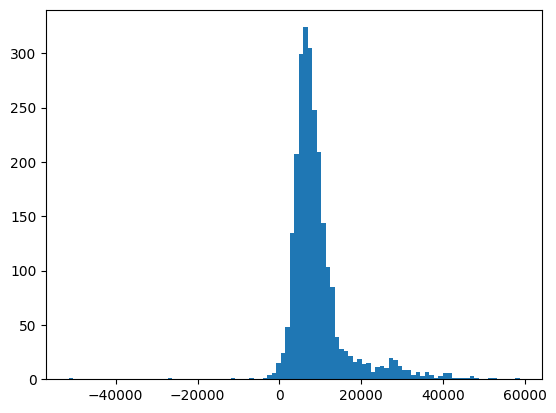

In [ ]:
plt.hist(s_medians_per_row,bins=100)

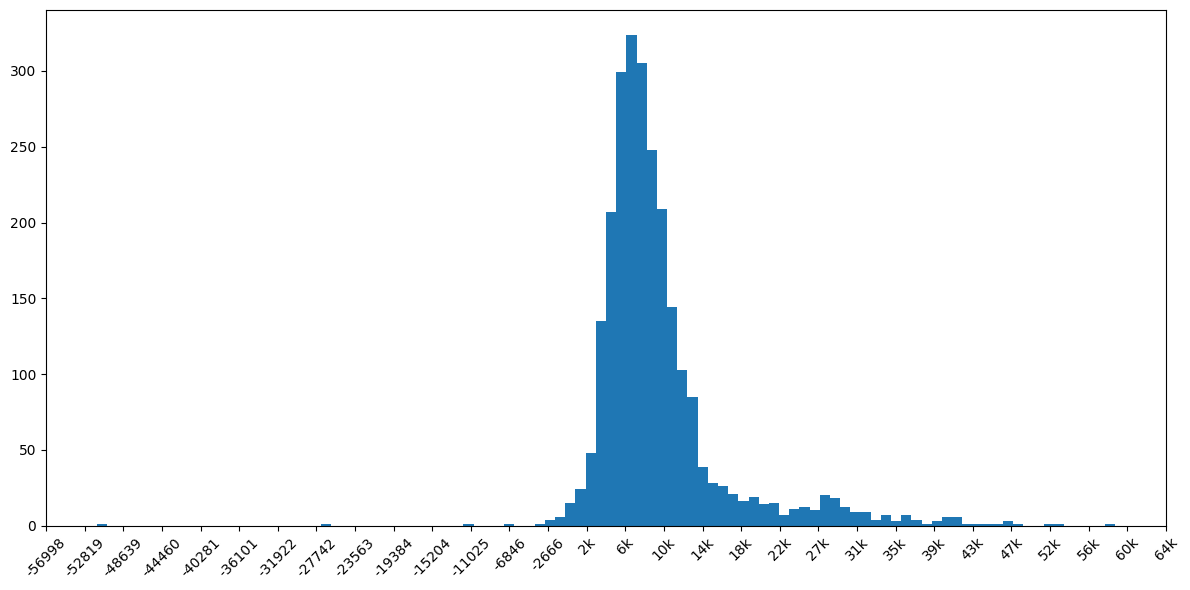

In [ ]:
import matplotlib.ticker as ticker


plt.figure(figsize=(12, 6))
plt.hist(s_medians_per_row, bins=100)

# Format x-axis to use 'k' notation
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{x/1000:.0f}k' if x >= 1000 else f'{x:.0f}'))

# Manually set the tick positions for even distribution
x_min, x_max = plt.xlim()
custom_ticks = np.linspace(x_min, x_max, 30)  # 15 ticks across the range
plt.xticks(custom_ticks, rotation=45)

plt.tight_layout()
plt.show()

C:\Users\ahmed\AppData\Local\Temp\ipykernel_43764\2604387526.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(s_medians_per_row,shade=True)


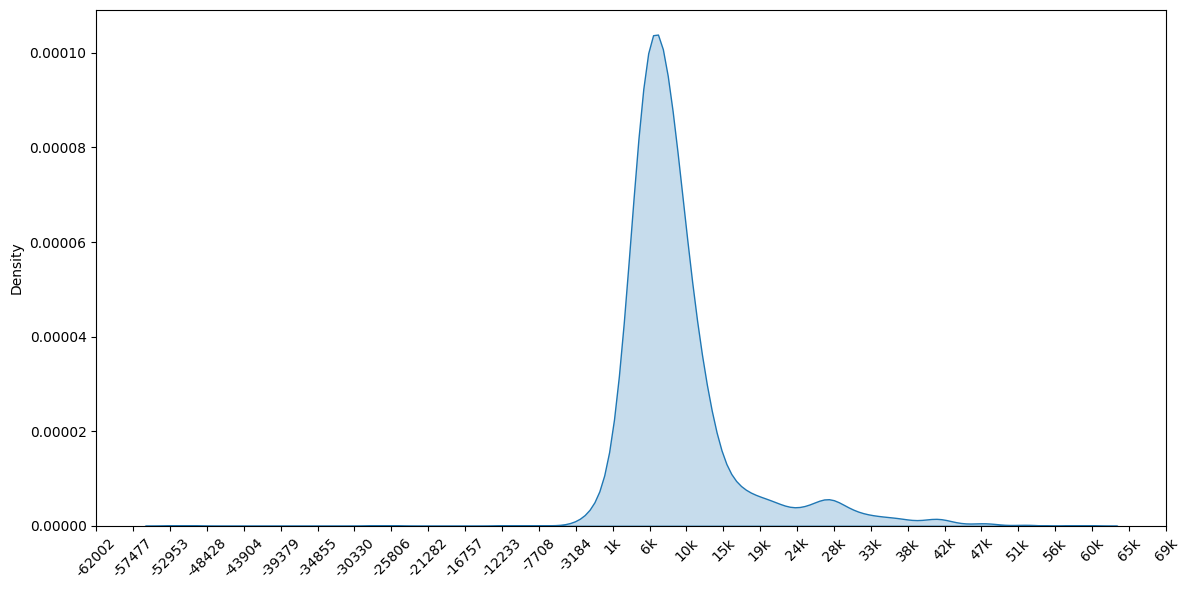

In [ ]:
plt.figure(figsize=(12, 6))
sns.kdeplot(s_medians_per_row,shade=True)
# Format x-axis to use 'k' notation
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{x/1000:.0f}k' if x >= 1000 else f'{x:.0f}'))

# Manually set the tick positions for even distribution
x_min, x_max = plt.xlim()
custom_ticks = np.linspace(x_min, x_max, 30)  # 15 ticks across the range
plt.xticks(custom_ticks, rotation=45)

plt.tight_layout()
plt.show()

(array([2.073e+03, 2.570e+02, 9.600e+01, 6.100e+01, 5.900e+01, 3.300e+01,
        4.700e+01, 4.600e+01, 3.400e+01, 3.600e+01, 2.700e+01, 6.300e+01,
        3.500e+01, 3.000e+01, 1.800e+01, 3.600e+01, 2.300e+01, 1.800e+01,
        1.300e+01, 3.600e+01, 2.000e+01, 1.400e+01, 7.000e+00, 2.400e+01,
        8.000e+00, 6.000e+00, 6.000e+00, 1.100e+01, 7.000e+00, 3.000e+00,
        8.000e+00, 9.000e+00, 7.000e+00, 1.000e+00, 3.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 8.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
        3.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 4.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        1.000e+00, 0.000e+00, 0.000e+0

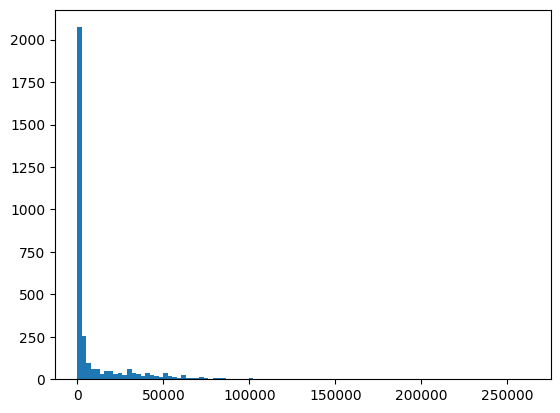

In [ ]:
plt.hist(df_main['own_value_ls'], bins=100)

In [ ]:
df_main['own_value_ls'].describe()

count      3206.000000
mean      10031.263672
std       21096.554688
min           0.000000
25%           0.000000
50%        1071.666626
75%        7000.000000
max      262300.000000
Name: own_value_ls, dtype: float64

In [ ]:
s_median_dict = {'s_median': s_medians_per_row}
s_median_df = pd.DataFrame(s_median_dict)
s_median_df.describe()

,s_median
count,2499.000000
mean,9302.715471
std,7249.514063
min,-51489.019531
25%,5417.464478
50%,7544.834229
75%,10531.465820
max,58694.843750


---

## **First let's Compare the models**

In [ ]:
small_lambda_blp = np.median(models_comparisons['small_lambda_blp'])
small_lambda_gates = np.median(models_comparisons['small_lambda_gates'])
print(F"small_lambda_blp: {small_lambda_blp.round(0)}, small_lambda_gates: {small_lambda_gates.round(0)}")

small_lambda_blp: 51624283.0, small_lambda_gates: 182594656.0


NN: small_lambda_blp: 51879186.868425295, small_lambda_gates: 188142249.3749832


In [ ]:
small_lambda_blp_normalized = np.median(models_comparisons['small_lambda_blp']) / df_main['own_value_ls'].var()
small_lambda_gates_normalized = np.median(models_comparisons['small_lambda_gates']) / df_main['own_value_ls'].var()
print(F"small_lambda_blp_normalized: {small_lambda_blp_normalized}, small_lambda_gates_normalized: {small_lambda_gates_normalized}")

small_lambda_blp_normalized: 0.11599277676796432, small_lambda_gates_normalized: 0.41026547579382294


- elasticnet: lambda_blp_normalized: 0.15897482512187378, lambda_gates_normalized: 0.5596844870804755
- xgboost: lambda_blp_normalized: 0.10458710928863613, lambda_gates_normalized: 0.49125177179907553
- Random Forest: lambda_blp_normalized: 0.243244078015595, lambda_gates_normalized: 0.5830742598858208
- catboost_100: lambda_blp_normalized: 0.21525394117555752, lambda_gates_normalized: 0.4747823367888713
- NN: lambda_blp_normalized: 0.08692043861869532, lambda_gates_normalized: 0.388215865677688

In [ ]:
df_main['own_value_ls'].var()

np.float32(445064640.0)

---

## **Second: For the best model, extract the results**

In [1]:
#results

In [ ]:
rows = []
for run_i, run in enumerate(results['blp'], start=1):
    for d in run:
        if 'name' in d:  # only coefficient rows
            rows.append({
                'run': run_i,
                'name': d['name'],
                'coef': float(d['coef']),
                'std_err': float(d['std_err']),
                'z': float(d['z']),
                'p': float(d['p']),
                'ci_low': float(d['ci_low']),
                'ci_high': float(d['ci_high']),
            })

df = pd.DataFrame(rows)

term = 'D-p_S(Z)_shifted'
s = df[df['name'] == term].set_index('run')['coef']
median_val = s.median()
run_with_median = (s - median_val).abs().idxmin()

blp_median_coef = (df[df['run'] == run_with_median]
       .reset_index(drop=True))

blp_median_coef 


,run,name,coef,std_err,z,p,ci_low,ci_high
0,84,D-p,11434.572513,1284.152766,8.904371,5.368966e-19,8917.679340,13951.465685
1,84,D-p_S(Z)_shifted,0.770387,0.269857,2.854799,4.306401e-03,0.241477,1.299296


---

In [ ]:
# ----- Flatten `results['gates']` (one row per split × group) -----
rows = []
for run in results['gates']:
    for d in run:
        rows.append({
            "group": int(d["group"]),
            "gamma": float(d["gamma"]),
            "std_err": float(d["std_err"]),
            "ci_low": float(d["ci_low"]),
            "ci_high": float(d["ci_high"]),
            # if your dict already has "p", we'll keep it; else we compute below
            "p": float(d["p"]) if "p" in d else np.nan,
        })

gdf = pd.DataFrame(rows)

# If p-values were not stored per split, approximate from gamma/std_err (two-sided normal)
if gdf["p"].isna().any():
    z = gdf["gamma"] / gdf["std_err"]
    gdf["p"] = 2 * (1 - norm.cdf(np.abs(z)))

# ----- Aggregate across splits EXACTLY like the R code (medians by group) -----
gates_summary = (
    gdf.groupby("group", as_index=False)
       .agg(gamma=("gamma", "median"),
       std_err=("std_err", "median"),
       ci_low=("ci_low", "median"),
       ci_high=("ci_high", "median"),
       p=("p", "median"),
       )

)

gates_summary


,group,gamma,std_err,ci_low,ci_high,p
0,1,6105.326288,2639.974607,939.787377,11446.562970,2.103994e-02
1,2,8435.060440,2355.512958,3864.223823,12996.787118,2.821766e-04
2,3,10469.633430,2500.919792,5585.458356,15459.408905,3.263631e-05
3,4,12894.341160,2862.434293,6936.078497,18411.614349,9.664421e-06
4,5,22307.827928,4267.559900,13747.883460,30444.579170,1.346557e-07


---

In [ ]:
rows = []
for run_i, run in enumerate(results['clan'], start=1):
    for d in run:
        r = {'run': run_i}
        r.update(d)
        rows.append(r)

df = pd.DataFrame(rows)

diff_col = 'Diff (G5 - G1)'

# drop rows with NaN diff (so medians/closest work cleanly)
df_ = df.dropna(subset=[diff_col]).copy()

# median diff per covariate
med = df_.groupby('covariate')[diff_col].median().rename('diff_median')

# find the row per covariate closest to its median
tmp = df_.merge(med, on='covariate', how='left')
idx = (tmp[diff_col] - tmp['diff_median']).abs().groupby(tmp['covariate']).idxmin()

clan = (tmp.loc[idx]
       .drop(columns=['diff_median'])
       .sort_values('covariate')
       .reset_index(drop=True))

clan

,run,covariate,Mean G1 (predicted least affected),Mean G5 (predicted most affected),Diff (G5 - G1),SE (Welch),z,p (two-sided),CI 95% lower,CI 95% upper
0,26,agri_own_size_quir,0.086000,0.320000,0.234000,0.090851,2.575657,1.000498e-02,0.055933,0.412067
1,25,agri_rent_amount_bl,28.240988,183.604935,155.363953,66.677271,2.330089,1.980147e-02,24.676501,286.051404
2,53,agri_rent_out_amount,13.600000,1.387045,-12.212955,10.333237,-1.181910,2.372415e-01,-32.466099,8.040190
3,35,agri_rent_out_siz_28,0.038000,0.016000,-0.022000,0.026834,-0.819846,4.123040e-01,-0.074595,0.030595
4,38,agri_rent_size_quir,0.096000,0.324000,0.228000,0.100796,2.261990,2.369801e-02,0.030439,0.425561
5,22,bl_fruit_trees_count,0.008000,0.048000,0.040000,0.019392,2.062754,3.913597e-02,0.001993,0.078007
6,62,consumed_ls_count,0.372000,2.068000,1.696000,0.282679,5.999732,1.976435e-09,1.141949,2.250052
7,60,dep_ratio,1.760071,1.610017,-0.150054,0.088203,-1.701237,8.889851e-02,-0.322932,0.022824
8,31,dwelling_rent,51.504517,3.844771,-47.659744,12.038940,-3.958799,7.532757e-05,-71.256066,-24.063422
9,3,fattening_ls_count,0.144000,0.480000,0.336000,0.162669,2.065540,3.887190e-02,0.017168,0.654832


In [ ]:
#additional_feature_drop = ['vehicle_motorcycle_e','vehicle_toktok_e','vehicle_tricycle_e','skip_meal_e','has_heater_e','has_fridge_e','cart_e','bicycle_e']

In [ ]:
clan[clan['p (two-sided)'] < 0.05].shape[0]

29

In [ ]:
clan[clan['p (two-sided)'] < 0.05]

,run,covariate,Mean G1 (predicted least affected),Mean G5 (predicted most affected),Diff (G5 - G1),SE (Welch),z,p (two-sided),CI 95% lower,CI 95% upper
0,26,agri_own_size_quir,0.086000,0.320000,0.234000,0.090851,2.575657,1.000498e-02,0.055933,0.412067
1,25,agri_rent_amount_bl,28.240988,183.604935,155.363953,66.677271,2.330089,1.980147e-02,24.676501,286.051404
4,38,agri_rent_size_quir,0.096000,0.324000,0.228000,0.100796,2.261990,2.369801e-02,0.030439,0.425561
5,22,bl_fruit_trees_count,0.008000,0.048000,0.040000,0.019392,2.062754,3.913597e-02,0.001993,0.078007
6,62,consumed_ls_count,0.372000,2.068000,1.696000,0.282679,5.999732,1.976435e-09,1.141949,2.250052
8,31,dwelling_rent,51.504517,3.844771,-47.659744,12.038940,-3.958799,7.532757e-05,-71.256066,-24.063422
9,3,fattening_ls_count,0.144000,0.480000,0.336000,0.162669,2.065540,3.887190e-02,0.017168,0.654832
10,55,food_exp_bl,270.353821,356.040985,85.687164,13.554586,6.321636,2.588081e-10,59.120175,112.254154
12,63,health_cant_work__61,5.112000,3.352000,-1.760000,0.548293,-3.209965,1.327510e-03,-2.834653,-0.685347
14,32,hh_max_attain,3.808000,4.612000,0.804000,0.193723,4.150262,3.320949e-05,0.424303,1.183696
